In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sklearn

In [ ]:
# build the NN model
class BSModel(nn.Module):

    def __init__(self, input_dim=2, hidden_dim1=100, hidden_dim2=50, output_dim=1):
        super(BSModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim1)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(hidden_dim2, hidden_dim2)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):

        out = self.fc1(x)
        out = self.relu1(out)

        out = self.fc2(out)
        out = self.relu2(out)

        out = self.fc3(out)
        out = self.relu3(out)

        out = self.fc4(out)
        out = self.relu4(out)

        out = self.fc5(out)

        return out

In [ ]:
# def the parameters
sigma = 0.2
r = 0.05
K = 100
T = 1  #1year
S_inf = 1000
k = 0.005
delta_t = 1/252
A = np.sqrt(2 / np.pi) * k / (sigma * np.sqrt(delta_t))


In [ ]:
A

0.3166506184233564

In [ ]:
model = BSModel()

In [ ]:
x = torch.tensor([[1, 2], [3,4]])

In [ ]:
x[:, 0]

tensor([1, 3])

In [ ]:
def bsm_loss_with_bc(model, inputs, K, S_inf, sigma, r, T):

    inputs.requires_grad = True
    V = model(inputs)
    S = inputs[:, 0].view(-1, 1)
    t = inputs[:, 1].view(-1, 1)

    # Take the derivative of V with respect to S and t
    V_S = torch.autograd.grad(V.sum(), inputs, create_graph=True, retain_graph=True)[0][:, 0]
    V_t = torch.autograd.grad(V.sum(), inputs, create_graph=True, retain_graph=True)[0][:, 1]
    V_SS = torch.autograd.grad(V_S.sum(), inputs, create_graph=True)[0][:, 0]


    adjusted_sigma = torch.tensor(sigma * torch.sqrt(1 + A * torch.sign(V_SS)))

    pde_loss = torch.mean((V_t + 0.5 * (sigma ** 2) * (S ** 2) * V_SS + r * S * V_S - r * V) ** 2)

    # Define the boundary condition loss
    bc_loss = 0

    # Boundary condition when t goes to T, V should approximate max(S-K, 0)
    V_expiry = model(torch.hstack((S, torch.full_like(t, T))))
    call_payoff = torch.maximum(S - K, torch.zeros_like(S))
    expiry_loss = torch.mean((V_expiry - call_payoff) ** 2)

    # Boundary condition when S goes to 0, then V should go to 0
    V_zero = model(torch.hstack((torch.zeros_like(S), t)))
    zero_loss = torch.mean(V_zero ** 2)

    # Boundary condition when S goes to S_inf, V should behave as S - K * exp(-r * (T - t))
    V_inf = model(torch.hstack((torch.full_like(S, S_inf), t)))
    inf_loss = torch.mean((V_inf - (S - K * torch.exp(-r * (T - t)))) ** 2)

    bc_loss = expiry_loss + zero_loss + inf_loss

    # Combine PDE and boundary losses
    total_loss = 0.9 * pde_loss + 0.1 * bc_loss

    return total_loss


In [ ]:
model.parameters

<bound method Module.parameters of BSModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=50, out_features=1, bias=True)
)>

In [ ]:
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
S_values = torch.linspace(0.0, 200.0, 2000).view(-1, 1)
t_values = torch.linspace(0.0, 1.0, 2000).view(-1, 1)

In [ ]:
input = torch.cat((S_values, t_values), dim=1)
input.shape

torch.Size([2000, 2])

In [ ]:
input[:, 0]

tensor([0.0000e+00, 1.0005e-01, 2.0010e-01,  ..., 1.9980e+02, 1.9990e+02,
        2.0000e+02])

In [ ]:
for epoch in range(10001):
    optimizer.zero_grad()
    loss = bsm_loss_with_bc(model, input, K, S_inf, sigma, r, T)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

D:\Program Files\miniconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch 0, Loss: 488.05926513671875
Epoch 100, Loss: 479.333251953125
Epoch 200, Loss: 468.7641296386719
Epoch 300, Loss: 434.96185302734375
Epoch 400, Loss: 408.0045471191406
Epoch 500, Loss: 390.4554748535156
Epoch 600, Loss: 379.3335266113281
Epoch 700, Loss: 362.95721435546875
Epoch 800, Loss: 364.9851989746094
Epoch 900, Loss: 343.8646240234375
Epoch 1000, Loss: 334.1059265136719
Epoch 1100, Loss: 326.75042724609375
Epoch 1200, Loss: 335.65802001953125
Epoch 1300, Loss: 315.6859436035156
Epoch 1400, Loss: 311.6868896484375
Epoch 1500, Loss: 307.0946044921875
Epoch 1600, Loss: 494.136474609375
Epoch 1700, Loss: 300.64776611328125
Epoch 1800, Loss: 296.8818054199219
Epoch 1900, Loss: 292.0458068847656
Epoch 2000, Loss: 286.14361572265625
Epoch 2100, Loss: 274.0419616699219
Epoch 2200, Loss: 250.52731323242188
Epoch 2300, Loss: 272.4630126953125
Epoch 2400, Loss: 238.68930053710938
Epoch 2500, Loss: 175.64337158203125
Epoch 2600, Loss: 156.35763549804688
Epoch 2700, Loss: 151.865463256

In [ ]:
S_values = torch.linspace(50, 220.0, 1000).view(-1, 1)
t_values = torch.linspace(0.0, 0.0, 1000).view(-1, 1)
input = torch.cat((S_values, t_values), dim=1)

In [ ]:
V_pred = model(input)

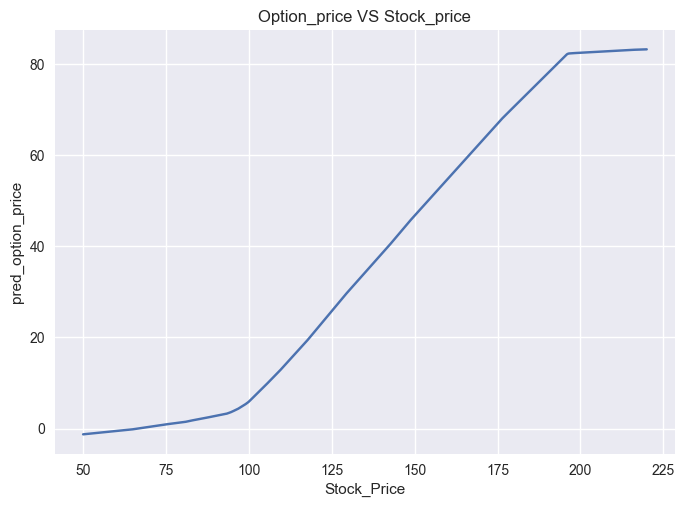

In [ ]:

%matplotlib inline
plt.style.use('seaborn')
plt.plot(S_values.numpy(), V_pred.detach().numpy())
plt.xlabel('Stock_Price')
plt.ylabel('pred_option_price')
plt.title('Option_price VS Stock_price')
plt.show()